In [1]:
from keras.layers import Input, Dense, Activation, Dropout, LeakyReLU, Lambda, PReLU
from keras.models import Model, Sequential, model_from_json
from matplotlib.backends.backend_pdf import PdfPages
from keras.callbacks import EarlyStopping
from keras import optimizers, activations, regularizers
from keras import backend as K
from sklearn.model_selection import train_test_split, KFold
from numpy import loadtxt
from keras.models import load_model, model_from_json
from keras.backend import sigmoid
from keras.utils.generic_utils import get_custom_objects
import json
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import h5py

Using TensorFlow backend.


In [2]:
class Swish(Activation):
    
    def __init__(self, activation, **kwargs):
        super(Swish, self).__init__(activation, **kwargs)
        self.__name__ = 'swish'

def swish(x):
    return (sigmoid(x) * x)

get_custom_objects().update({'swish': Swish(swish)})

In [3]:
'''1x1 filter'''
with open('/Users/maggiezhang/Dropbox/AtmosphereMachineLearning/DensityData/Models/1x1final12.json','r') as f:
    model_encoder_json = json.load(f)
    model_encoder_json = json.dumps(model_encoder_json)
    model_encoder_json = str(model_encoder_json)

model_encoder = model_from_json(model_encoder_json)
#weights =h5py.File('/Users/maggiezhang/Desktop/1x1filter120.h5', 'r')
model_encoder.load_weights('/Users/maggiezhang/Desktop/1x1filter120.h5')
model_encoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 24, 20, 36, 1)     0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 24, 20, 1, 795)    29415     
_________________________________________________________________
batch_normalization_1 (Batch (None, 24, 20, 1, 795)    96        
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 24, 1, 1, 204)     3243804   
_________________________________________________________________
batch_normalization_2 (Batch (None, 24, 1, 1, 204)     96        
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 1, 1, 1, 934)      4573798   
_________________________________________________________________
batch_normalization_3 (Batch (None, 1, 1, 1, 934)      4   

In [4]:
encoder_model_1x1 = Model(inputs=model_encoder.input, outputs=model_encoder.layers[8].output)
encoder_model_1x1.summary()

decode_input = Input(model_encoder.layers[9].input_shape[1:])
decoder_model_1x1 = decode_input
for layer in model_encoder.layers[9:]:
    decoder_model_1x1 = layer(decoder_model_1x1)
decoder_model_1x1 = Model(inputs=decode_input, outputs=decoder_model_1x1)

decoder_model_1x1.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 24, 20, 36, 1)     0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 24, 20, 1, 795)    29415     
_________________________________________________________________
batch_normalization_1 (Batch (None, 24, 20, 1, 795)    96        
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 24, 1, 1, 204)     3243804   
_________________________________________________________________
batch_normalization_2 (Batch (None, 24, 1, 1, 204)     96        
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 1, 1, 1, 934)      4573798   
_________________________________________________________________
batch_normalization_3 (Batch (None, 1, 1, 1, 934)      4   

In [5]:
xdata= np.load("NRLMSISE_concat_data.npy")
xdata_1 = np.log10(xdata)
xmat = (xdata_1 - np.mean(xdata_1, keepdims=True)) / np.std(xdata_1, keepdims=True)
xmat = np.reshape(xmat, (105192, 24, 20, 36, 1))
full_sw = scipy.io.loadmat("/Users/maggiezhang/Dropbox/AtmosphereMachineLearning/DensityData/SWdata_NRLMSISE_1997_2008_smooth.mat")
full_sw = full_sw['SWdataFullSmooth']
print(full_sw.shape)


(105192, 11)


In [6]:
dens_data = encoder_model_1x1.predict(xmat)
print(dens_data.shape)

(105192, 10)


In [23]:
data = scipy.io.loadmat('/Users/maggiezhang/Desktop/NRLMSISE_1997_2008_ROM_r100.mat')
dens_data = data.get('densityDataLogVarROM100')
dens_data = np.array(dens_data).T

# Space weather data
sw_data = data.get('SWdataFull')
sw_data = np.array(sw_data)
#sw_data = sw_data.transpose()

In [24]:

pred_number = 24

# Only consider first 10 modes/dimensions of reduced data
dens_data = dens_data[:,0:10]

'''Training data'''
# Training input

split_15 = int(dens_data.shape[0]*0.85) # manual test split 

dens_data_train = dens_data[0:split_15-pred_number,:]
sw_data_train = sw_data[0:split_15-pred_number,:]
sw_data_train_append = sw_data[1:split_15-pred_number+1,:] #looks at next sw timestep because it could be useful in prediction 
sw_data_train = np.concatenate((sw_data_train, sw_data_train_append), axis=1)
# Input is reduced-order density and space weather data
x_train = np.concatenate((dens_data_train, sw_data_train), axis=1)
# Training output
y_train = dens_data[1:split_15-pred_number+1,:]

'''ROM LINEAR MATRICES''' 
Om = np.append(np.transpose(dens_data_train), np.transpose(sw_data_train), axis = 0)
X2 = np.transpose(y_train)

# Compute dynamic matrices:
# Phi = X2*pinv(Om)
Phi = np.matmul(X2,np.linalg.pinv(Om))

r = 10 #reduced order 
A = Phi[:r, :r]
B = Phi[:r, r:]

'''Test data'''
# Test input
dens_data_test = dens_data[split_15-pred_number-1:-pred_number-2,:]
sw_data_test = sw_data[split_15-pred_number-1:-pred_number-2,:]
sw_data_test_append = sw_data[split_15-pred_number:-pred_number-1,:]
sw_data_test = np.concatenate((sw_data_test, sw_data_test_append), axis = 1)
# Input is reduced-order density and space weather data
x_test = np.concatenate((dens_data_test, sw_data_test), axis=1)

# Test output
y_test = dens_data[split_15-pred_number:-pred_number-1,:]

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.17647) #, random_state=42)

In [19]:
model = Sequential()
model.add(Dense(120, kernel_initializer='random_uniform'))
model.add(LeakyReLU(alpha=0.3))
model.add(Dense(40, kernel_initializer='random_uniform'))
model.add(LeakyReLU(alpha=0.3))
model.add(Dense(20, kernel_initializer='random_uniform'))
model.add(LeakyReLU(alpha=0.3))
model.add(Dense(10, kernel_initializer='random_uniform'))
ad = optimizers.Adam(learning_rate=0.0005, beta_1=0.9, beta_2=0.999, amsgrad=False)
model.compile(optimizer=ad, loss='mse', metrics=['accuracy'])

In [52]:
history = model.fit(x = x_train, y = y_train, validation_data = (x_val, y_val), epochs = 500, batch_size = 32)

Train on 73614 samples, validate on 15775 samples
Epoch 1/500
73614/73614 [==============================] - 2s 27us/step - loss: 0.0042 - accuracy: 0.9974 - val_loss: 0.0043 - val_accuracy: 0.9969
Epoch 2/500
73614/73614 [==============================] - 2s 27us/step - loss: 0.0042 - accuracy: 0.9972 - val_loss: 0.0036 - val_accuracy: 0.9968
Epoch 3/500
73614/73614 [==============================] - 2s 27us/step - loss: 0.0041 - accuracy: 0.9972 - val_loss: 0.0061 - val_accuracy: 0.9978
Epoch 4/500
73614/73614 [==============================] - 2s 27us/step - loss: 0.0040 - accuracy: 0.9970 - val_loss: 0.0044 - val_accuracy: 0.9971
Epoch 5/500
73614/73614 [==============================] - 2s 26us/step - loss: 0.0043 - accuracy: 0.9973 - val_loss: 0.0087 - val_accuracy: 0.9977
Epoch 6/500
73614/73614 [==============================] - 2s 27us/step - loss: 0.0041 - accuracy: 0.9972 - val_loss: 0.0074 - val_accuracy: 0.9968
Epoch 7/500
73614/73614 [==============================] - 2s 

Epoch 56/500
73614/73614 [==============================] - 2s 27us/step - loss: 0.0038 - accuracy: 0.9974 - val_loss: 0.0037 - val_accuracy: 0.9982
Epoch 57/500
73614/73614 [==============================] - 2s 27us/step - loss: 0.0039 - accuracy: 0.9975 - val_loss: 0.0032 - val_accuracy: 0.9978
Epoch 58/500
73614/73614 [==============================] - 2s 26us/step - loss: 0.0042 - accuracy: 0.9972 - val_loss: 0.0036 - val_accuracy: 0.9974
Epoch 59/500
73614/73614 [==============================] - 2s 26us/step - loss: 0.0037 - accuracy: 0.9974 - val_loss: 0.0058 - val_accuracy: 0.9971
Epoch 60/500
73614/73614 [==============================] - 2s 26us/step - loss: 0.0042 - accuracy: 0.9974 - val_loss: 0.0026 - val_accuracy: 0.9980
Epoch 61/500
73614/73614 [==============================] - 2s 26us/step - loss: 0.0042 - accuracy: 0.9974 - val_loss: 0.0038 - val_accuracy: 0.9975
Epoch 62/500
73614/73614 [==============================] - 2s 26us/step - loss: 0.0038 - accuracy: 0.9974

Epoch 111/500
73614/73614 [==============================] - 2s 28us/step - loss: 0.0036 - accuracy: 0.9974 - val_loss: 0.0023 - val_accuracy: 0.9985
Epoch 112/500
73614/73614 [==============================] - 2s 27us/step - loss: 0.0039 - accuracy: 0.9975 - val_loss: 0.0090 - val_accuracy: 0.9951
Epoch 113/500
73614/73614 [==============================] - 2s 27us/step - loss: 0.0037 - accuracy: 0.9977 - val_loss: 0.0034 - val_accuracy: 0.9990
Epoch 114/500
73614/73614 [==============================] - 2s 27us/step - loss: 0.0037 - accuracy: 0.9975 - val_loss: 0.0032 - val_accuracy: 0.9975
Epoch 115/500
73614/73614 [==============================] - 2s 29us/step - loss: 0.0038 - accuracy: 0.9974 - val_loss: 0.0041 - val_accuracy: 0.9973
Epoch 116/500
73614/73614 [==============================] - 2s 27us/step - loss: 0.0040 - accuracy: 0.9975 - val_loss: 0.0024 - val_accuracy: 0.9986
Epoch 117/500
73614/73614 [==============================] - 2s 28us/step - loss: 0.0037 - accuracy:

Epoch 220/500
73614/73614 [==============================] - 2s 25us/step - loss: 0.0037 - accuracy: 0.9975 - val_loss: 0.0064 - val_accuracy: 0.9970
Epoch 221/500
73614/73614 [==============================] - 2s 25us/step - loss: 0.0034 - accuracy: 0.9976 - val_loss: 0.0056 - val_accuracy: 0.9974
Epoch 222/500
73614/73614 [==============================] - 2s 25us/step - loss: 0.0034 - accuracy: 0.9977 - val_loss: 0.0027 - val_accuracy: 0.9985
Epoch 223/500
73614/73614 [==============================] - 2s 25us/step - loss: 0.0035 - accuracy: 0.9977 - val_loss: 0.0049 - val_accuracy: 0.9972
Epoch 224/500
73614/73614 [==============================] - 2s 25us/step - loss: 0.0035 - accuracy: 0.9975 - val_loss: 0.0068 - val_accuracy: 0.9975
Epoch 225/500
73614/73614 [==============================] - 2s 26us/step - loss: 0.0033 - accuracy: 0.9976 - val_loss: 0.0053 - val_accuracy: 0.9980
Epoch 226/500
73614/73614 [==============================] - 2s 25us/step - loss: 0.0035 - accuracy:

Epoch 329/500
73614/73614 [==============================] - 2s 25us/step - loss: 0.0033 - accuracy: 0.9977 - val_loss: 0.0041 - val_accuracy: 0.9963
Epoch 330/500
73614/73614 [==============================] - 2s 25us/step - loss: 0.0034 - accuracy: 0.9974 - val_loss: 0.0037 - val_accuracy: 0.9981
Epoch 331/500
73614/73614 [==============================] - 2s 26us/step - loss: 0.0034 - accuracy: 0.9978 - val_loss: 0.0084 - val_accuracy: 0.9970
Epoch 332/500
73614/73614 [==============================] - 2s 25us/step - loss: 0.0032 - accuracy: 0.9976 - val_loss: 0.0024 - val_accuracy: 0.9987
Epoch 333/500
73614/73614 [==============================] - 2s 25us/step - loss: 0.0031 - accuracy: 0.9975 - val_loss: 0.0043 - val_accuracy: 0.9982
Epoch 334/500
73614/73614 [==============================] - 2s 26us/step - loss: 0.0032 - accuracy: 0.9974 - val_loss: 0.0044 - val_accuracy: 0.9980
Epoch 335/500
73614/73614 [==============================] - 2s 26us/step - loss: 0.0033 - accuracy:

Epoch 438/500
73614/73614 [==============================] - 2s 26us/step - loss: 0.0032 - accuracy: 0.9977 - val_loss: 0.0025 - val_accuracy: 0.9984
Epoch 439/500
73614/73614 [==============================] - 2s 26us/step - loss: 0.0030 - accuracy: 0.9977 - val_loss: 0.0022 - val_accuracy: 0.9986
Epoch 440/500
73614/73614 [==============================] - 2s 26us/step - loss: 0.0031 - accuracy: 0.9977 - val_loss: 0.0030 - val_accuracy: 0.9972
Epoch 441/500
73614/73614 [==============================] - 2s 25us/step - loss: 0.0031 - accuracy: 0.9977 - val_loss: 0.0034 - val_accuracy: 0.9974
Epoch 442/500
73614/73614 [==============================] - 2s 26us/step - loss: 0.0030 - accuracy: 0.9979 - val_loss: 0.0029 - val_accuracy: 0.9987
Epoch 443/500
73614/73614 [==============================] - 2s 26us/step - loss: 0.0032 - accuracy: 0.9978 - val_loss: 0.0022 - val_accuracy: 0.9982
Epoch 444/500
73614/73614 [==============================] - 2s 26us/step - loss: 0.0031 - accuracy:

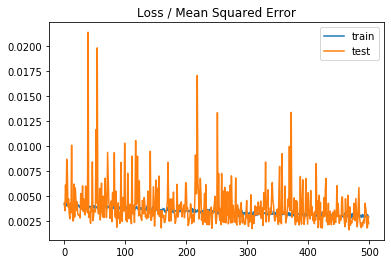

In [54]:
plt.figure()
plt.title('Loss / Mean Squared Error')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()

In [55]:
model_json = model.to_json()
with open("NN_model_NRLMSISE_1x1.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("NN_model_NRLMSISE_1x1.h5")
print("Saved model")

Saved model


[[0.01951879 0.03914652 0.05629102 0.07366176 0.0920679  0.11171567
  0.1326219  0.15456942 0.17750055 0.20142147 0.22626473 0.25209059
  0.27894158 0.30686556 0.33595961 0.36628732 0.3978456  0.43066163
  0.46471503 0.49992014 0.53625795 0.57376498 0.61250158 0.65264269]]
[[0.0730793  0.24985528 0.50182695 0.81260242 1.14795964 1.48797291
  1.82753735 2.14323684 2.42593438 2.68066433 2.89459148 3.06673618
  3.20735964 3.31325556 3.39012388 3.45279835 3.49793934 3.53073367
  3.56540137 3.59962081 3.63932255 3.69892447 3.77562789 3.87310541]]
[ 3.7440478   6.38256615  8.9148675  11.0315364  12.46861962 13.31928574
 13.78005716 13.86585331 13.66719358 13.30873156 12.79294168 12.16521499
 11.49832053 10.79709149 10.09086746  9.4264751   8.79220317  8.19839394
  7.67223168  7.20039171  6.78651494  6.44675884  6.16427455  5.93449592]


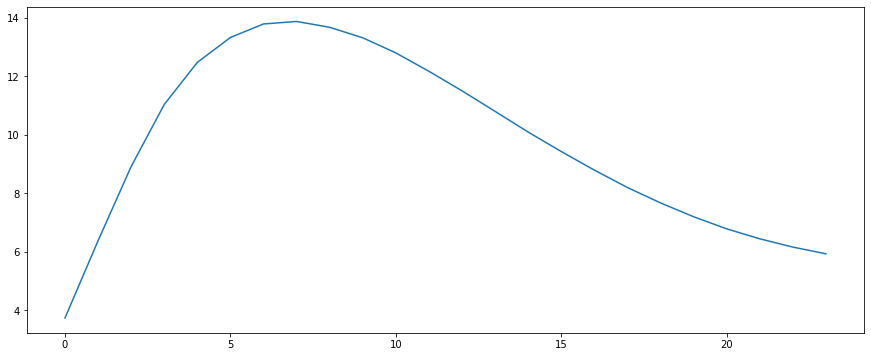

In [26]:
mse_NN = np.zeros((1,pred_number))
mse_ROM = np.zeros((1,pred_number))

x_test_rom = np.copy(x_test)
x_test_NN = np.copy(x_test)
y_test_NN = np.copy(y_test)

prediction_NN = np.empty((15778,10))
prediction_POD = np.empty((15778,10))

for b in range(pred_number):
    y_pred = model_NN.predict(x_test_NN)
    y_test_NN = dens_data[split_15-pred_number+b:-pred_number-1+b,:]
    mse_num = 0
    for i in range(len(y_pred)):
        for j in range(len(y_pred[0])):
            mse_num += (y_pred[i][j] - y_test_NN[i][j])**2
    mse_NN[0][b] = mse_num/(y_pred.shape[0]*y_pred.shape[1])
    y_pred_error = abs(y_pred-y_test_NN)
    mse2 = np.zeros(y_pred_error.shape[0])
    for i1 in range(len(y_pred_error)):
        for j1 in range(len(y_pred_error[0])):
            mse2[i1] += y_pred_error[i1][j1]**2
        mse2[i1] = mse2[i1]/(y_pred_error.shape[1])
    
    sw_data_test = sw_data[split_15-pred_number+b:-pred_number-1+b,:]
    sw_data_test_append = sw_data[split_15-pred_number+1+b:-pred_number+b,:]
    sw_data_test = np.concatenate((sw_data_test, sw_data_test_append), axis = 1)
    x_test_NN = np.concatenate((y_pred, sw_data_test), axis=1)

print(mse_NN) 

for a in range(pred_number):
    #General
    y_test = dens_data[split_15-pred_number+a:-pred_number-1+a,:]
    sw_data_test = sw_data[split_15-pred_number-1+a:-pred_number-2+a,:]
    sw_data_test_append = sw_data[split_15-pred_number+a:-pred_number-1+a,:]
    sw_data_test = np.concatenate((sw_data_test, sw_data_test_append), axis = 1)
    if (a!= 0):
        x_test_rom = np.concatenate((x_test_rom, sw_data_test), axis=1)
    #x_test = np.concatenate((y_test, sw_data_test), axis=1)

    #ROM
    sw_data_test_ROM = x_test_rom[:,10:]
    dens_data_test_ROM = x_test_rom[:,:10]
    XfullPred = np.transpose(np.matmul(A,np.transpose(dens_data_test_ROM)) + np.matmul(B,np.transpose(sw_data_test_ROM)))
    #print(XfullPred.shape)
    prediction_POD = np.append(prediction_POD, XfullPred, axis =0)
    x_test_rom = np.copy(XfullPred)
    errFullPred = abs(XfullPred-y_test)
    mse_rom = 0 
    for x in range(len(errFullPred)):
        for y in range(len(errFullPred[0])):
            mse_rom += errFullPred[x][y]**2
    mse_ROM[0][a] = mse_rom/(errFullPred.shape[0]*errFullPred.shape[1])
    mse_rom2 = np.zeros(errFullPred.shape[0])
    for i2 in range(len(errFullPred)):
        for j2 in range(len(errFullPred[0])):
            mse_rom2[i2] += errFullPred[i2][j2]**2
        mse_rom2[i2] = mse_rom2[i2]/(errFullPred.shape[1])
    
print(mse_ROM) 

factor = np.zeros((pred_number))
for i in range(pred_number):
    factor[i] = mse_ROM[0][i]/mse_NN[0][i]
print(factor)

plt.figure(figsize = (15,6))
plt.plot(factor)

 

(array([-0.5,  0. ,  0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5]),
 <a list of 11 Text yticklabel objects>)

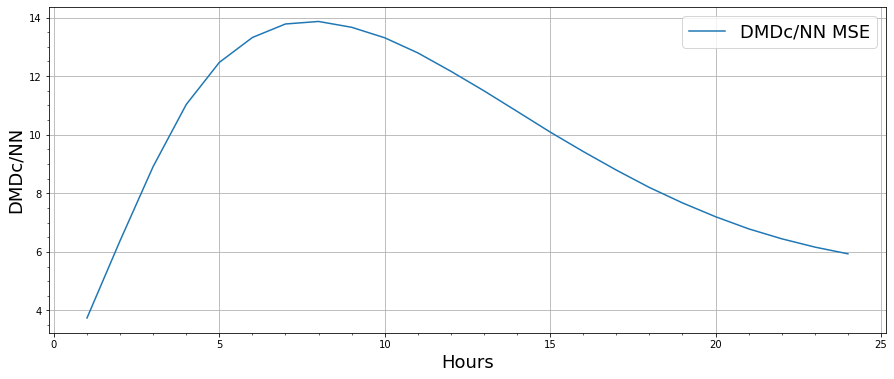

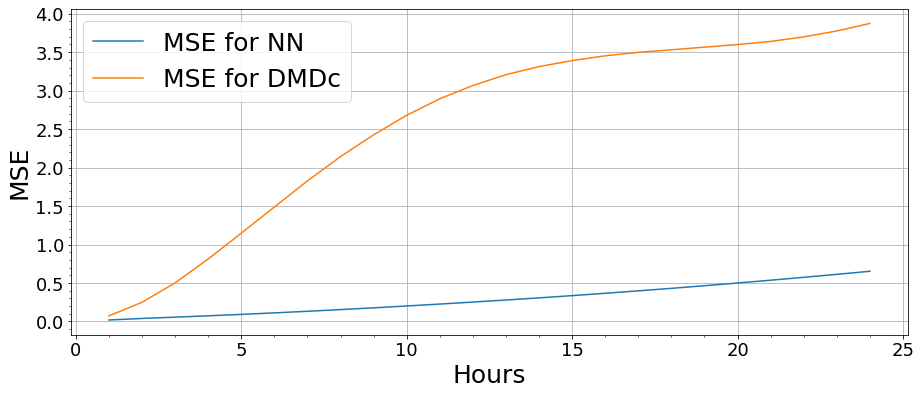

In [27]:
plt.figure(figsize = (15,6))
#plt.title("NRLMSISE 1997-2008: DMDc/NN MSE for 24 Hours Time Series using 1x1 Autoencoder")
plt.plot(range(1,1+len(factor)),factor, label = "DMDc/NN MSE")
#ratio.set_xlim(1,len(factor))
plt.grid()
plt.minorticks_on()
#ax.grid(which='minor', linestyle=':', linewidth='0.3', color='black')
plt.legend(fontsize=18)
plt.xlabel("Hours", fontsize=18)
plt.ylabel("DMDc/NN", fontsize=18)
#plt.savefig('1x1_AE_DMDc/NN_Ratio.png')  
#plt.show()


plt.figure(figsize = (15,6))
#plt.title("NRLMSISE 1997-2008: Comparison of MSE for 24 Hours Time Series using 1x1 Autoencoder")
plt.plot(range(1,1+len(factor)),mse_NN.T, label = "MSE for NN")
#norm_mse.set_xlim(1,len(factor))
plt.plot(range(1,1+len(factor)),mse_ROM.T, label = "MSE for DMDc")
plt.grid()
plt.minorticks_on()
#ax.grid(which='minor', linestyle=':', linewidth='0.', color='black')
plt.xlabel("Hours",fontsize=25)
plt.ylabel("MSE",fontsize=25)
plt.legend(fontsize=25)
plt.xticks(size = 18)
plt.yticks(size = 18)


In [25]:
with open('NRLMSIS_POD.json','r') as f:
    model_NN_json = json.load(f)
    model_NN_json = json.dumps(model_NN_json)
    model_NN_json = str(model_NN_json)

model_NN = model_from_json(model_NN_json)
model_NN.load_weights('NRLMSIS_POD.h5')
model_NN.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 120)               3960      
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 120)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 40)                4840      
_________________________________________________________________
leaky_re_lu_11 (LeakyReLU)   (None, 40)                0         
_________________________________________________________________
dense_15 (Dense)             (None, 20)                820       
_________________________________________________________________
leaky_re_lu_12 (LeakyReLU)   (None, 20)                0         
_________________________________________________________________
dense_16 (Dense)             (None, 10)               

In [9]:
x_test_NN = x_test[0,:]
x_test_NN= np.reshape(x_test_NN, (1, 32))
x_test_rom = np.reshape(x_test[0,:10], (1, 10))

NN_prediction = None
for b in range(pred_number):
    y_pred = model_NN.predict(x_test_NN)
    if b == 0:
        NN_prediction = y_pred
    else:
        NN_prediction = np.append(NN_prediction, y_pred, axis = 0)
    sw_data_test = np.reshape(sw_data[b,:], (1,11))
    sw_data_test_append = np.reshape(sw_data[b+1,:],(1,11))
    sw_data_test = np.concatenate((sw_data_test, sw_data_test_append), axis = 1)
    x_test_NN = np.concatenate((y_pred, sw_data_test), axis=1)
    
DMDc_prediction = None
for a in range(pred_number):
    #General
    sw_data_test = np.reshape(sw_data[a,:], (1,11))
    sw_data_test_append = np.reshape(sw_data[a+1,:], (1,11))
    sw_data_test = np.concatenate((sw_data_test, sw_data_test_append), axis = 1)
    x_test_rom = np.transpose(np.matmul(A,np.transpose(x_test_rom)) + np.matmul(B,np.transpose(sw_data_test)))
    if not a:
        DMDc_prediction = x_test_rom
    else:
        DMDc_prediction = np.append(DMDc_prediction, x_test_rom, axis = 0)


In [10]:
#print(NN_prediction)
#print(DMDc_prediction)
nndecoded = None
DMDcdecoded = None
for i in range(1,25):
    nn_data = NN_prediction[i-1:i,:]
    decoded_nn = decoder_model_1x1.predict(nn_data)
    DMDc_data = DMDc_prediction[i-1:i,:]
    decoded_DMDc = decoder_model_1x1.predict(DMDc_data)
    if i == 1:
        nndecoded = decoded_nn
        DMDcdecoded = decoded_DMDc
    else:
        nndecoded = np.append(nndecoded, decoded_nn, axis = 0)
        DMDcdecoded = np.append(DMDcdecoded, decoded_DMDc, axis = 0)
print(nndecoded.shape)
print(DMDcdecoded.shape)

(24, 17280)
(24, 17280)


In [11]:
MSISEstd = np.std(xdata_1, keepdims=True)
MSISEmean = np.mean(xdata_1, keepdims=True)

In [12]:
nndecoded = nndecoded*MSISEstd + MSISEmean
DMDcdecoded = DMDcdecoded*MSISEstd + MSISEmean
tens = np.full((24,17280), 10)
nndecoded = np.power(tens, nndecoded)
DMDcdecoded = np.power(tens, DMDcdecoded)

In [1]:
#print(XfullPred.shape)
#print(XfullPred[0].shape)
#U = data.get('U100')
#densityDataMeanLog = data.get('densityDataMeanLog')
#print(densityDataMeanLog.shape)
#XfullPred_full = np.matmul(U[:,:10], XfullPred[-1])
#print(XfullPred_full.shape)
#XfullPred_full = np.reshape(XfullPred_full + densityDataMeanLog[:,0],(24,20,36),order='F')
#print(XfullPred_full.shape)
nndecoded_1 = np.reshape(nndecoded[0,:], (24, 20, 36), order = "f")
#altitude_18 = nndecoded_1[:,:,18]
fig, ax = plt.subplots(constrained_layout=True)
CS = ax.contourf(range(24), np.asarray(range(20))*87.5*2/19 - 87.5, 10**nndecoded_1[:,:,18].T, 25)
ax.set_xlabel('Local solar time [hours]')
ax.set_ylabel('Latitude [deg]')
cbar = fig.colorbar(CS)
cbar.ax.set_ylabel('Density [kg/m^3]')

NameError: name 'np' is not defined

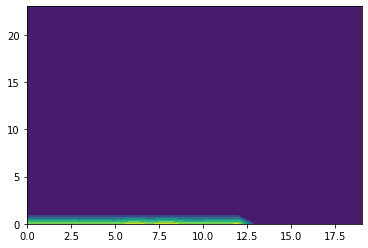

In [19]:
"""Plot densities"""
nndecoded_1 = np.reshape(nndecoded[0,:], (24, 20, 36))
altitude_18 = nndecoded_1[:,:,18]
CS = plt.contourf(altitude_18)
cbar = plt.colorbar(CS)
cbar.ax.set_ylabel('verbosity coefficient')

In [ ]:
plt.figure()
plt.plot(nndecoded[:,0])
plt.plot(nndecoded[:,1])
plt.plot(nndecoded[:,2])
print(nndecoded[:,2].shape)


plt.figure()
plt.plot(DMDcdecoded[:,0])
plt.plot(DMDcdecoded[:,1])
plt.plot(DMDcdecoded[:,2])

print(xdata[split_15:split_15+1,:].shape)

#plt.figure()
#plt.plot(xdata[split_15:split_15+1,:])

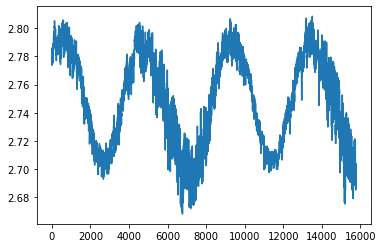

In [92]:
decoded_NN = decoder_model_1x1.predict(prediction_NN)
plt.plot(decoded_NN[:, 10])
#decoded_POD = decoder_model_1x1.predict(prediction_POD)

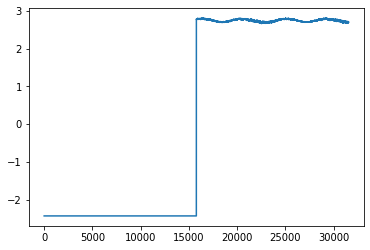

In [89]:
plt.plot(decoded_NN[:, 0])

(31556, 17280)


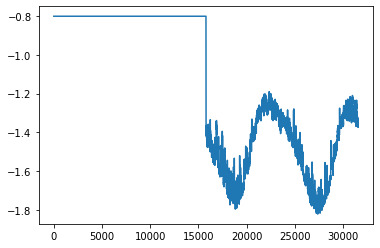

In [90]:
print(decoded_NN.shape)
plt.plot(decoded_NN[:,17279])

In [85]:
decoded_NN = decoded_NN*np.std(xdata_1, keepdims=True) + np.mean(xdata_1, keepdims=True)

#xmat = (xdata_1 - np.mean(xdata_1, keepdims=True)) / np.std(xdata_1, keepdims=True)

In [86]:
tens = np.full((15778,17280), 10)
decoded_NN = np.power(tens, decoded_NN)

ValueError: operands could not be broadcast together with shapes (15778,17280) (31556,17280) 

In [ ]:
plt.figure()
plt.plot(decoded_NN[:,0])
plt.figure()
plt.plot(xdata[:,0])